In [3]:
import requests
import json
import time
import pandas as pd
import matplotlib.pyplot as  plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('./sample data/Metrics-2.csv')
# Popping Datetime column from csv
date_time = pd.to_datetime(df.pop('Time'), format='%d/%m/%y %H:%M')
type(date_time)

pandas.core.series.Series

In [5]:
# Convert date_time column to seconds
def convert_to_seconds(time_array) -> pd.Series:
    timestamp_s = pd.Series(time_array).map(pd.Timestamp.timestamp)
    return(timestamp_s)

In [6]:
timestamp_s = convert_to_seconds(date_time)

In [7]:
def create_sin_with_period(timestamp_s,period_in_sec=86400):
    '''
    Create sine wave feature for the given time period
    input: timestamp array in seconds
    period: wavelength of the sinewave in sec
    '''
    return(np.sin(timestamp_s * (2 * np.pi / period_in_sec)))

In [8]:
day = 86400
df['day_sin'] = create_sin_with_period(timestamp_s,day)

In [9]:
def standardization(train_df):
    '''
    returns standardized model from the training dataset
    this should be used with test and validation set
    '''
    standard_scaler = StandardScaler()
    standard_scaler.fit(np.array(train_df).reshape(-1,1))
    return(standard_scaler)

In [10]:
def train_test_val_split(df,train_percentage=0.8,val_percentage=0.1):
    '''
    Splits the data into train, test and validation
    '''
    train_split = int(len(df)*train_percentage)
    val_split = int(len(df)*val_percentage) + train_split
    train_df = df[:train_split]
    val_df = df[train_split:val_split]
    test_df = df[val_split:]
    return(train_df,val_df,test_df)

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, batch_size=32,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.batch_size = batch_size
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])
      return inputs, labels
    def plot(self, model=None, plot_col='Requests_Sum', max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

      plt.xlabel('Time [m]')
    
    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
      ds = ds.map(self.split_window)
      return ds

    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.val_df)

    @property
    def test(self):
      return self.make_dataset(self.test_df)

    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result

In [12]:
train_df,val_df,test_df = train_test_val_split(df)
standardization_model = standardization(train_df['Requests_Sum'])


In [13]:
train_df['Requests_Sum'] = standardization_model.transform(np.array(train_df['Requests_Sum']).reshape(-1,1))
val_df['Requests_Sum'] = standardization_model.transform(np.array(val_df['Requests_Sum']).reshape(-1,1))
test_df['Requests_Sum'] = standardization_model.transform(np.array(test_df['Requests_Sum']).reshape(-1,1))

/var/folders/yh/zrm_sz7x0jz59t2rgs0n6sdr0000gn/T/ipykernel_13139/1543453332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Requests_Sum'] = standardization_model.transform(np.array(train_df['Requests_Sum']).reshape(-1,1))
/var/folders/yh/zrm_sz7x0jz59t2rgs0n6sdr0000gn/T/ipykernel_13139/1543453332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Requests_Sum'] = standardization_model.transform(np.array(val_df['Requests_Sum']).reshape(-1,1))
/var/folders/yh/zrm_sz7x0jz59t2rgs0n6sdr00

In [14]:
# w1 = WindowGenerator(input_width=24, label_width=1, shift=1,train_df=train_df,test_df=test_df,val_df=val_df,
#                      label_columns=['Requests_Sum'],batch_size=32)
OUT_STEPS = 720
multi_window = WindowGenerator(input_width=720,label_width=720,shift=100,
                               train_df=train_df,test_df=test_df,val_df=val_df,
                               label_columns=['Requests_Sum'],batch_size=32)

In [15]:
def compile_and_fit(model, window, patience=2,max_epochs=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [17]:
num_features = 2
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

# multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
# multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Epoch 1/2


ValueError: in user code:

    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/hassanraha/.pyenv/versions/3.8.8/envs/forecast/lib/python3.8/site-packages/keras/losses.py", line 1327, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 720 and 100 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_1/reshape_1/Reshape, IteratorGetNext:1)' with input shapes: [?,720,1], [?,100,1].


In [298]:
v = multi_lstm_model.predict(np.array(multi_window.test_df[:OUT_STEPS]).reshape(-1,OUT_STEPS,2))

1/1 [==============================] - 0s 18ms/step


In [299]:
v_df = pd.DataFrame(v.reshape(-1,1),columns=['r'])

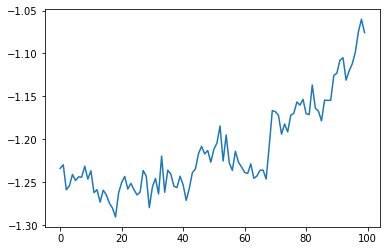

In [301]:
plt.plot(v_df)
# plt.plot(multi_window.test_df[:100])

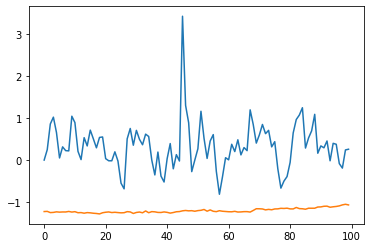

In [302]:
vy_df = val_df
vy_df = vy_df.reset_index()
plt.plot(vy_df['Requests_Sum'][:100])
plt.plot(v_df)

In [280]:
v_df

,r
0,0.452925
1,0.478031
2,0.473714
3,0.448554
4,0.430091
...,...
715,-1.267955
716,-1.261342
717,-1.228194
718,-1.230793
